For this first deliverable, I need to develop this:
<br /> 1.- Apply scaling techniques
<br /> 2.- preprocess of data

In [5]:
# Since maybe I'll use my home computer instead of the colab, I'll list the install comands:

# =================================
# PLEASE ONLY RUN ONCE, THEN COMMENT
# THIS SECTION AGAIN.
# =================================

#%pip install numpy
#%pip install pandas
#%pip install tensorflow
#%pip install matplotlib
#%pip install scipy

In [6]:
# All the imports come here
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D

In [7]:
# It's important to comment the import depending on the OS
# Windows PC
base_dir = r"./dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = "/content/drive/MyDrive/Octavo Semestre/IA/car dataset/car parts"

In [8]:
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# I will ommit the test directory for now. I don't want to mix the test data with the training data

In [9]:
# Time to preprocess the data

# SCALING
# First, scale pixels from 0-255 to 0-1, also augment my data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range = 10,
		width_shift_range = 0.2,
		#	height_shift_range = 0.2,
		#	shear_range = 0.3,
		zoom_range = 0.3,
		horizontal_flip = True)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range = 10,
		width_shift_range = 0.8,
		#	height_shift_range = 0.2,
		#	shear_range = 0.3,
		zoom_range = 0.5,
		horizontal_flip = True)


# PREPROCESS
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # My images are 254x254
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
)


# Let's get the dictionary
class_indices = train_generator.class_indices
print(class_indices)

Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.
{'AIR COMPRESSOR': 0, 'ALTERNATOR': 1, 'BATTERY': 2, 'BRAKE CALIPER': 3, 'BRAKE PAD': 4, 'BRAKE ROTOR': 5, 'CAMSHAFT': 6, 'CARBERATOR': 7, 'COIL SPRING': 8, 'CRANKSHAFT': 9, 'CYLINDER HEAD': 10, 'DISTRIBUTOR': 11, 'ENGINE BLOCK': 12, 'FUEL INJECTOR': 13, 'FUSE BOX': 14, 'GAS CAP': 15, 'HEADLIGHTS': 16, 'IDLER ARM': 17, 'IGNITION COIL': 18, 'LEAF SPRING': 19, 'LOWER CONTROL ARM': 20, 'MUFFLER': 21, 'OIL FILTER': 22, 'OIL PAN': 23, 'OVERFLOW TANK': 24, 'OXYGEN SENSOR': 25, 'PISTON': 26, 'RADIATOR': 27, 'RADIATOR FAN': 28, 'RADIATOR HOSE': 29, 'RIM': 30, 'SPARK PLUG': 31, 'STARTER': 32, 'TAILLIGHTS': 33, 'THERMOSTAT': 34, 'TORQUE CONVERTER': 35, 'TRANSMISSION': 36, 'VACUUM BRAKE BOOSTER': 37, 'VALVE LIFTER': 38, 'WATER PUMP': 39}


In [10]:
# I want to generate all images before going to the model
x_train = []
y_train = []

for i in range(len(train_generator)):
    x, y = train_generator[i]
    x_train.append(x)
    y_train.append(y)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Preload also the validation dataset
x_val = []
y_val = []

for i in range(len(valid_generator)):
    x, y = valid_generator[i]
    x_val.append(x)
    y_val.append(y)

x_val = np.concatenate(x_val)
y_val = np.concatenate(y_val)

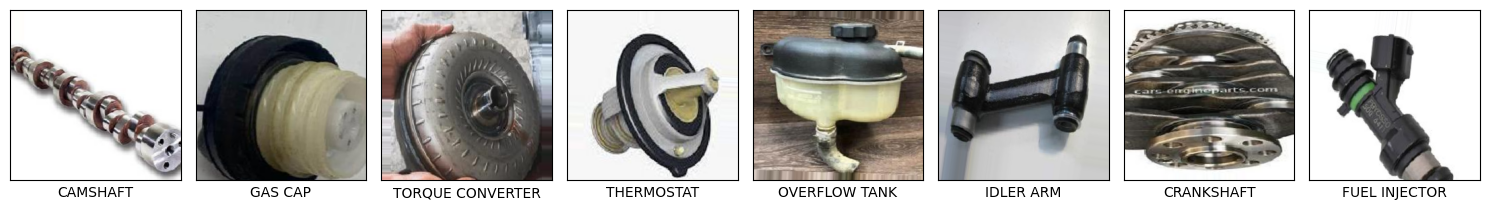

In [11]:
# Just to check if the data is loading correctly
# Let's visualize some images from the training set

# get class from index, from the dictionary
index_to_class = {i: j for j, i in train_generator.class_indices.items()}

plt.figure(figsize=(15, 15))

# Let's show 8 images
for i in range(8):
    img, label = next(train_generator)
    plt.subplot(1, 8, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[0])
    class_index = np.argmax(label[0])
    plt.xlabel(index_to_class[class_index])
plt.tight_layout()
plt.show()

In [12]:
# ResNet50
# Retrieved from documentation

with tf.device('/GPU:0'):
  ResNet50 = tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(254, 254, 3),
      pooling=None,
  )

  ResNet50.trainable = False

  model = tf.keras.models.Sequential([
      ResNet50,
      GlobalAveragePooling2D(),
      Dense(128, activation = 'relu'),
      Dense(40, activation = 'softmax')
  ])

  model.summary()

  model.layers[0].trainable = False

# CATEGORICAL CROSS SENTROPY

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,855,144 (91.00 MB)

 Trainable params: 267,432 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Time to add a checkpoint

# I want it on the same spot on every device, It's easier

# Drive
# checkpoint_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-{epoch:02d}.weights.h5"

# Windows
checkpoint_path = os.path.join(r"./", "checkpoints", "cp-{epoch:02d}.weights.h5")


# Mac OS
# checkpoint_path = PUTSOMETHINGHERE

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_freq='epoch',
                            save_weights_only=True, verbose=1)

In [ ]:
def compile_model_simple(model):
    model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

def train_model_simple(model, scaled_train_images, scaled_train_labels):
    history = model.fit(scaled_train_images, scaled_train_labels, epochs = 50, callbacks=[checkpoint])
    return history

: 

In [ ]:
compile_model_simple(model)
history = train_model_simple(model, x_train, y_train)

Epoch 1/50
 41/217 ━━━━━━━━━━━━━━━━━━━━ 9:46 3s/step - accuracy: 0.0323 - loss: 3.8190

In [ ]:
frame = pd.DataFrame(history.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")